# Classification problem: EAD and model analysis utilities
## Can be useful for standard machine learning problems

### Data ingestion, cleaning and transformation

In [1]:
%reload_ext autoreload
%autoreload 2

import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from copy import deepcopy

#Importing some helper functions.  
import utils as data_utils

import seaborn as sns

#Setting some things to ensure that we can see the dataframe properly. 
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 800)
pd.set_option('display.expand_frame_repr', False)

#Importing custom RC file to make beauftiful figures. 
plt.style.use('mypresentation.mplstyle')

#Seeding the generator to ensure reproducible results. 
np.random.seed(1000)
random_state = 1000


For classification, we go with the Titanic dataset. 

In [2]:
#Load the dataset and visualize.
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


From this, we can figure out the variables which are numeric and which are categorical. In case we wish to transform these from one to the other, that can be done as well. 

In [4]:
# Transform pclass to categorical where required. Some cleaning may also be necessary. 
df["pclass"] = df["pclass"].astype("category")
df["survived"] = df["survived"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    category
 1   pclass       891 non-null    category
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(4), float64(2), int64(2), object(5)
memory usage: 68.7+ KB


In [5]:
target_variable = "survived"
numerical_variables = ["age", "sibsp", "parch", "fare"]
categorical_variables = ["pclass", "sex", "embarked", "class", "who", 
                         "adult_male", "deck", "embark_town", "alive", "alone"]

Identify missing values per column. 

Text(0, 0.5, 'Percentage of filled values (%)')

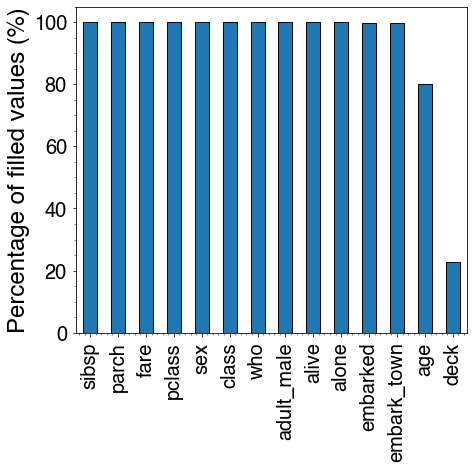

In [6]:
# Identify the number of missing values in each dataset.
missing_series = df[numerical_variables + categorical_variables].count() / df.shape[0] * 100
missing_series.sort_values(ascending=False).plot.bar().set_ylabel("Percentage of filled values (%)")

Notice that only 20% values are available for _deck_. So, we drop it.

In [7]:
#Drop variable.
categorical_variables.remove("deck")

Analyze numerical data to identify outliers and figure out their distribution.

### Single variable analysis

#### Numerical variables

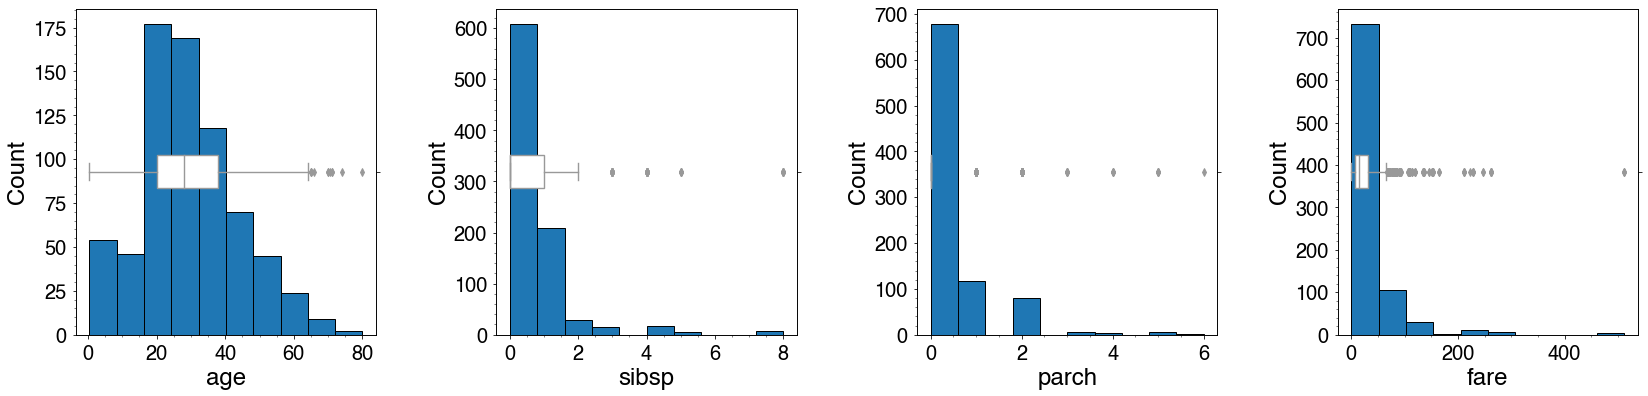

In [8]:
data_utils.make_histograms(df, numerical_variables, ncols=4)

__Use:__ Gives the user an idea about the spread and distribution of the data, the interquartile range, and the potential outliers. 

#### Categorical variables

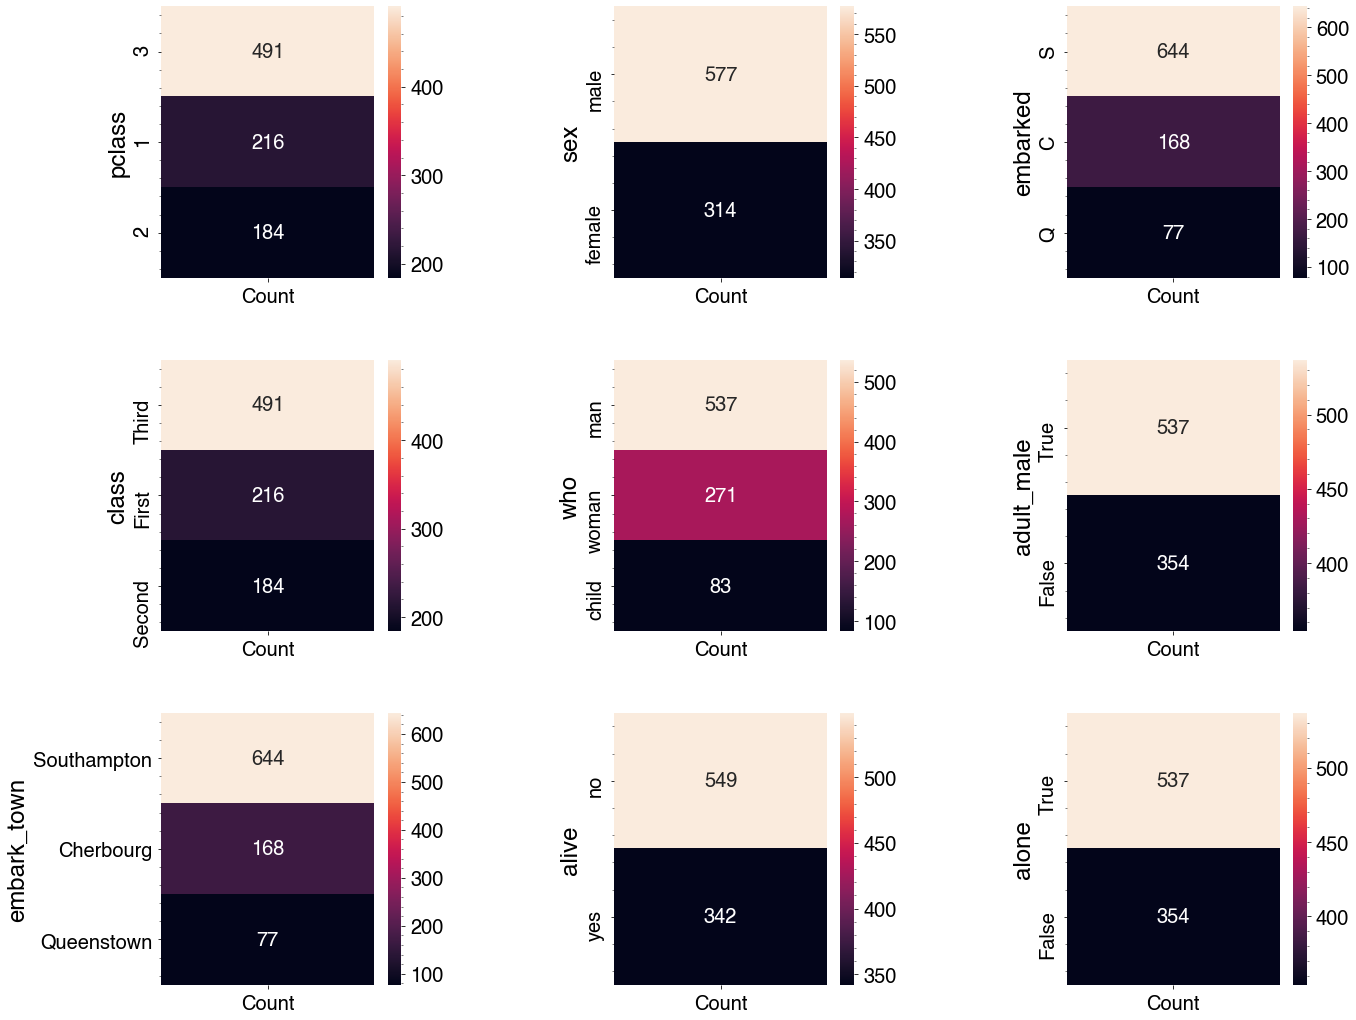

In [9]:
data_utils.make_count_tables(df, categorical_variables, ncols=3)

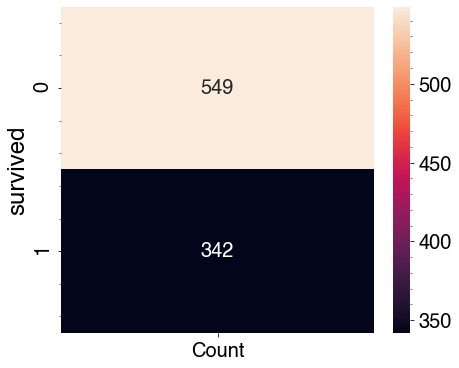

In [10]:
#Getting counts for the target variable.
data_utils.make_count_tables(df, [target_variable], ncols=1)

__Use:__ 
1. Let's say from this, we see that there are some variables which have many categories with only a few values each. In this case, we can choose to combine them into a few. 
2. For the target variable, we can identify imbalance. 

## Checking multicollinearity between feature variables

### Numerical features
Make correlation tables to see the correlation. 

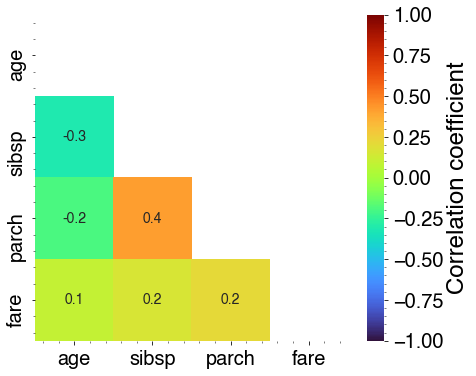

In [11]:
data_utils.make_correlation_table(df, numerical_variables)

*__Observation:__* None of the numerical features seem to be correlated with each other.
If they were, we could have performed some dimensionality reduction or dropped variables and rechecked their correlation. 

### Categorical features
To analyze how categorical variables are related to each other, we make contingency tables. 

A contingency table plots the frequency of each category of the one variable against each category of the other variable. Additionally, we sum it along the row to see how many values there are for the category.  

Given that there are 9 features 9, which means we would have to analyze 81 contingency tables, perhaps it better to do this one at a time.  

In [12]:
df[categorical_variables]

,pclass,sex,embarked,class,who,adult_male,embark_town,alive,alone
0,3,male,S,Third,man,True,Southampton,no,False
1,1,female,C,First,woman,False,Cherbourg,yes,False
2,3,female,S,Third,woman,False,Southampton,yes,True
3,1,female,S,First,woman,False,Southampton,yes,False
4,3,male,S,Third,man,True,Southampton,no,True
...,...,...,...,...,...,...,...,...,...
886,2,male,S,Second,man,True,Southampton,no,True
887,1,female,S,First,woman,False,Southampton,yes,True
888,3,female,S,Third,woman,False,Southampton,no,False
889,1,male,C,First,man,True,Cherbourg,yes,True


From the values here, we could suspect that the _pclass_ and _class_ denote the same information as do _embarked_ and _embark_town_. 
So, we look at them more closely.

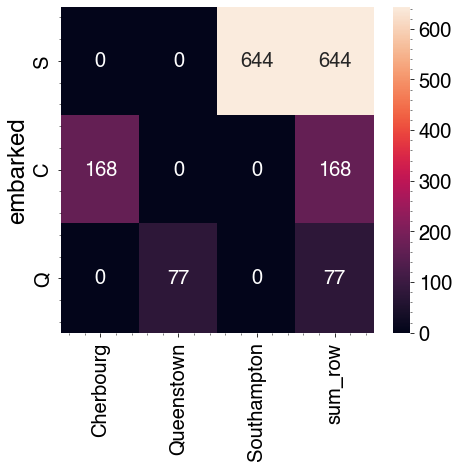

In [13]:
data_utils.make_contingency_tables_for_multiclass(df, ["embarked"], target_var="embark_town" , ncols=1)

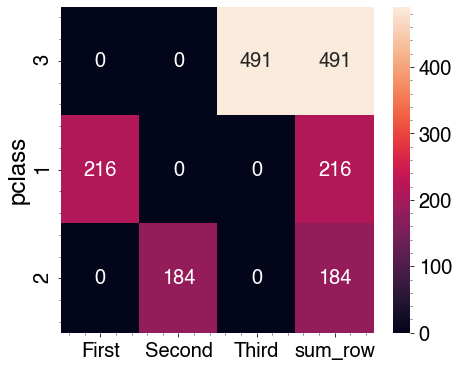

In [14]:
data_utils.make_contingency_tables_for_multiclass(df, ["pclass"], target_var="class" , ncols=1)

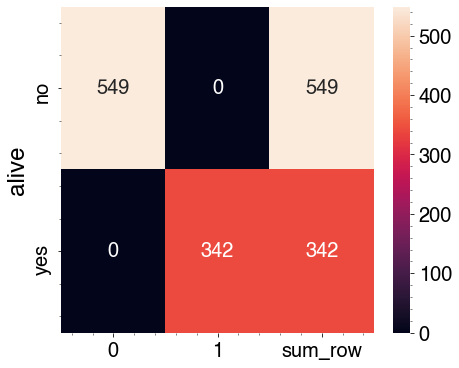

In [15]:
data_utils.make_contingency_tables_for_multiclass(df, ["alive"], target_var=target_variable, ncols=1)

__*Observation:*__ In all three cases, we can see that there is a 1:1 relation between the various categories. 
For instance: 3:Third and so on. 
So, we drop _pclass_, _embarked_, and _alive_ features . 

In [16]:
categorical_variables.remove("pclass")
categorical_variables.remove("embarked")
categorical_variables.remove("alive")


## Connecting the input features with the target variable
Now that we have analyzed the data by themselves, we see which ones might potentially be important features. 

### Numerical features

__Use:__ When the target variable is categorical and the feature variables to analyze are numeric, we analyze them using violinplots. Each violin shows the distribution of the numeric variable for the given value of the target variable.  

The dashed line shows the median and the dotted lines show the 25<sup>th</sup> and 75<sup>th</sup> quartile. 
If we notice that the medians of the distribution or the distributions themselves are different, the numerical feature may be important to the classification. 

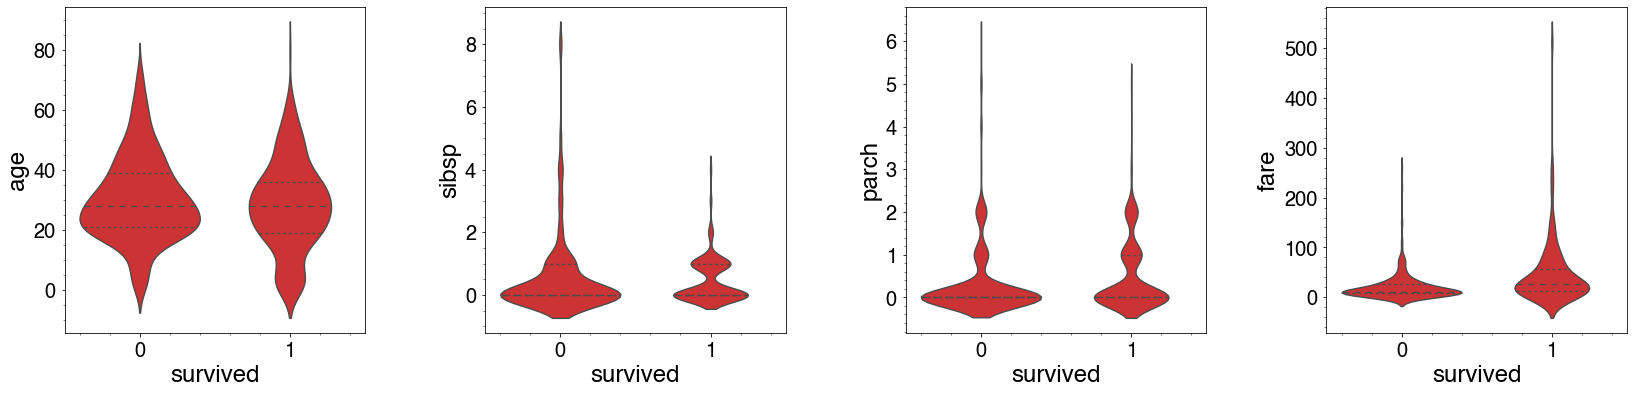

In [17]:
data_utils.make_violinplots(df, numerical_variables, target_variable, ncols=4)

### Categorical features

__Use:__ 
When the target variable as well as the feature variable are categorical, how do we judge if the feature variable might be important to the target variable prediction? 
We make a [contingency table](https://www.statisticshowto.com/what-is-a-contingency-table/). A contingency table plots the frequency of each category of the feature variable against each category of the target variable and sum it along the row to see how many values there are for the category.  

__*When target variable is binary*__: When the target variable is binary (with classes labelled as _0_ and _1_), we also add another column called _percentage_point_difference_. This indicates the difference in percentage of values in the positive class (_1_) and that between the negative class (_0_). 

$$Percentage\ point\ difference = \frac{Freq.\ class\ 1 - Freq.\ class\ 0} {Freq.\ class\ 1 + Freq.\ class\ 0} \times 100 $$

A higher difference indicates a larger separaration between the classes. 

For instance, in _sex_, we see that the percentage point difference for _male_ is _-62_. This means that a lot more males died (81%) than survived (19%). 

How to spot if the variable might be important? If the _percentage point difference_ between categories varies a lot, we can expect that the categorical variable is important. 

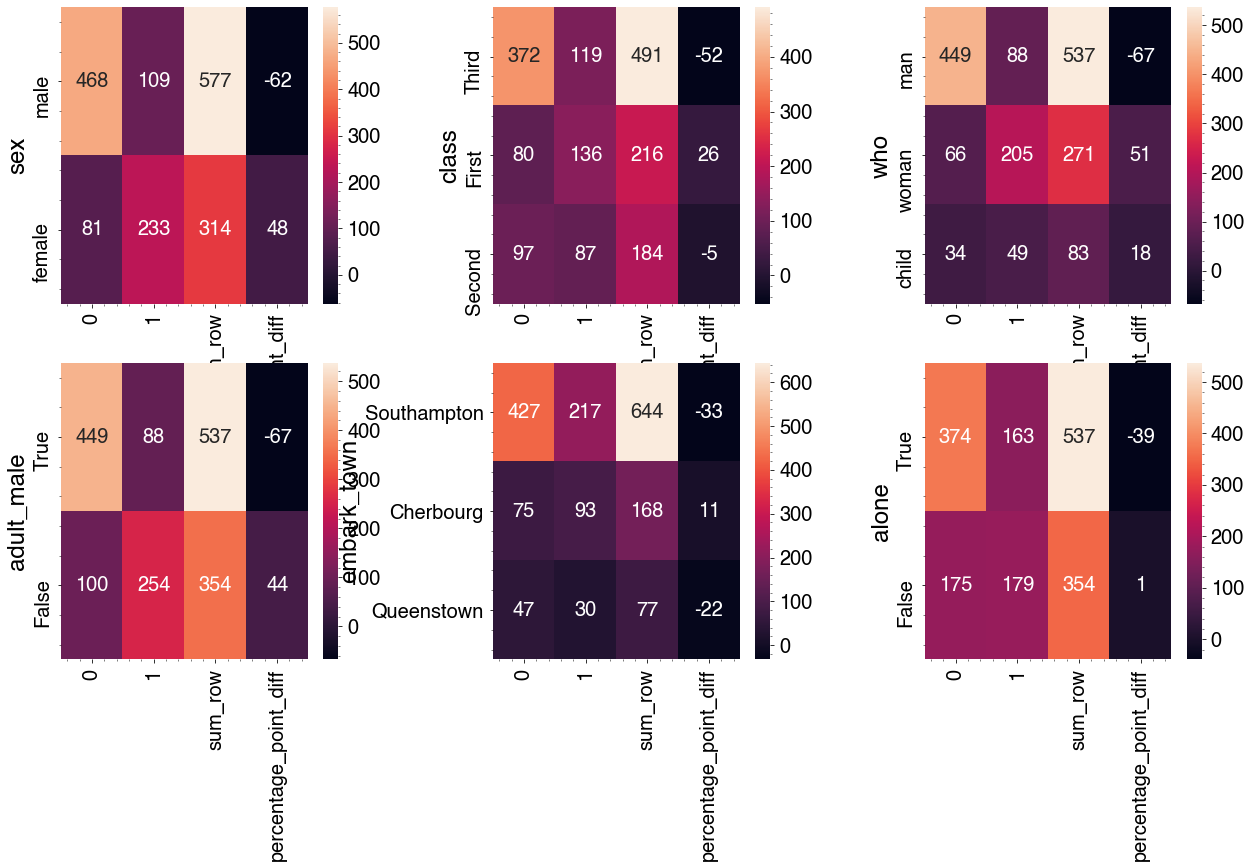

In [18]:
data_utils.make_contingency_tables_for_binary(df, categorical_variables, target_var=target_variable , ncols=3)

__*For general multiclass target variable:*__
In this case, we also have an option to simply show the frequencies and their sum without actually showing percentage point differences. We can infer the distributions by eyeballing them. 

In [19]:
# data_utils.make_contingency_tables_for_multiclass(df, categorical_variables, target_var=target_variable , ncols=3)

### Visualization in 2 Dimensions
Now, we might wish to see if secondary interactions affect the output data. 

#### Numerical-Numerical: Pairplots


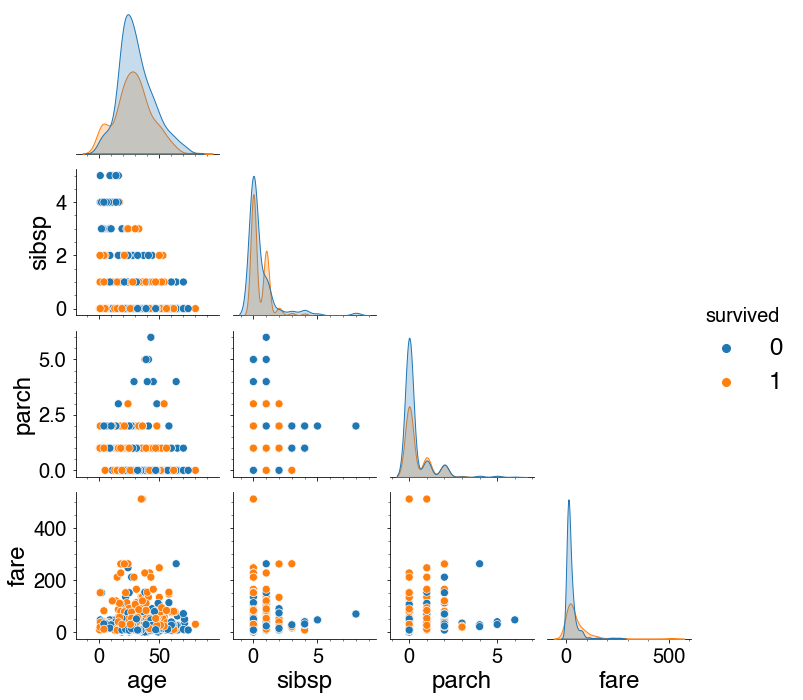

In [20]:
sns.pairplot(data = df[numerical_variables+[target_variable]], hue=target_variable, dropna=True, corner=True)

*__Observation:__* Seems like there are no significant effects any of the numeric variables have. 

#### Numerical + Categorical

Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1240 ticks ([-0.4, ..., 247.4]), which exc

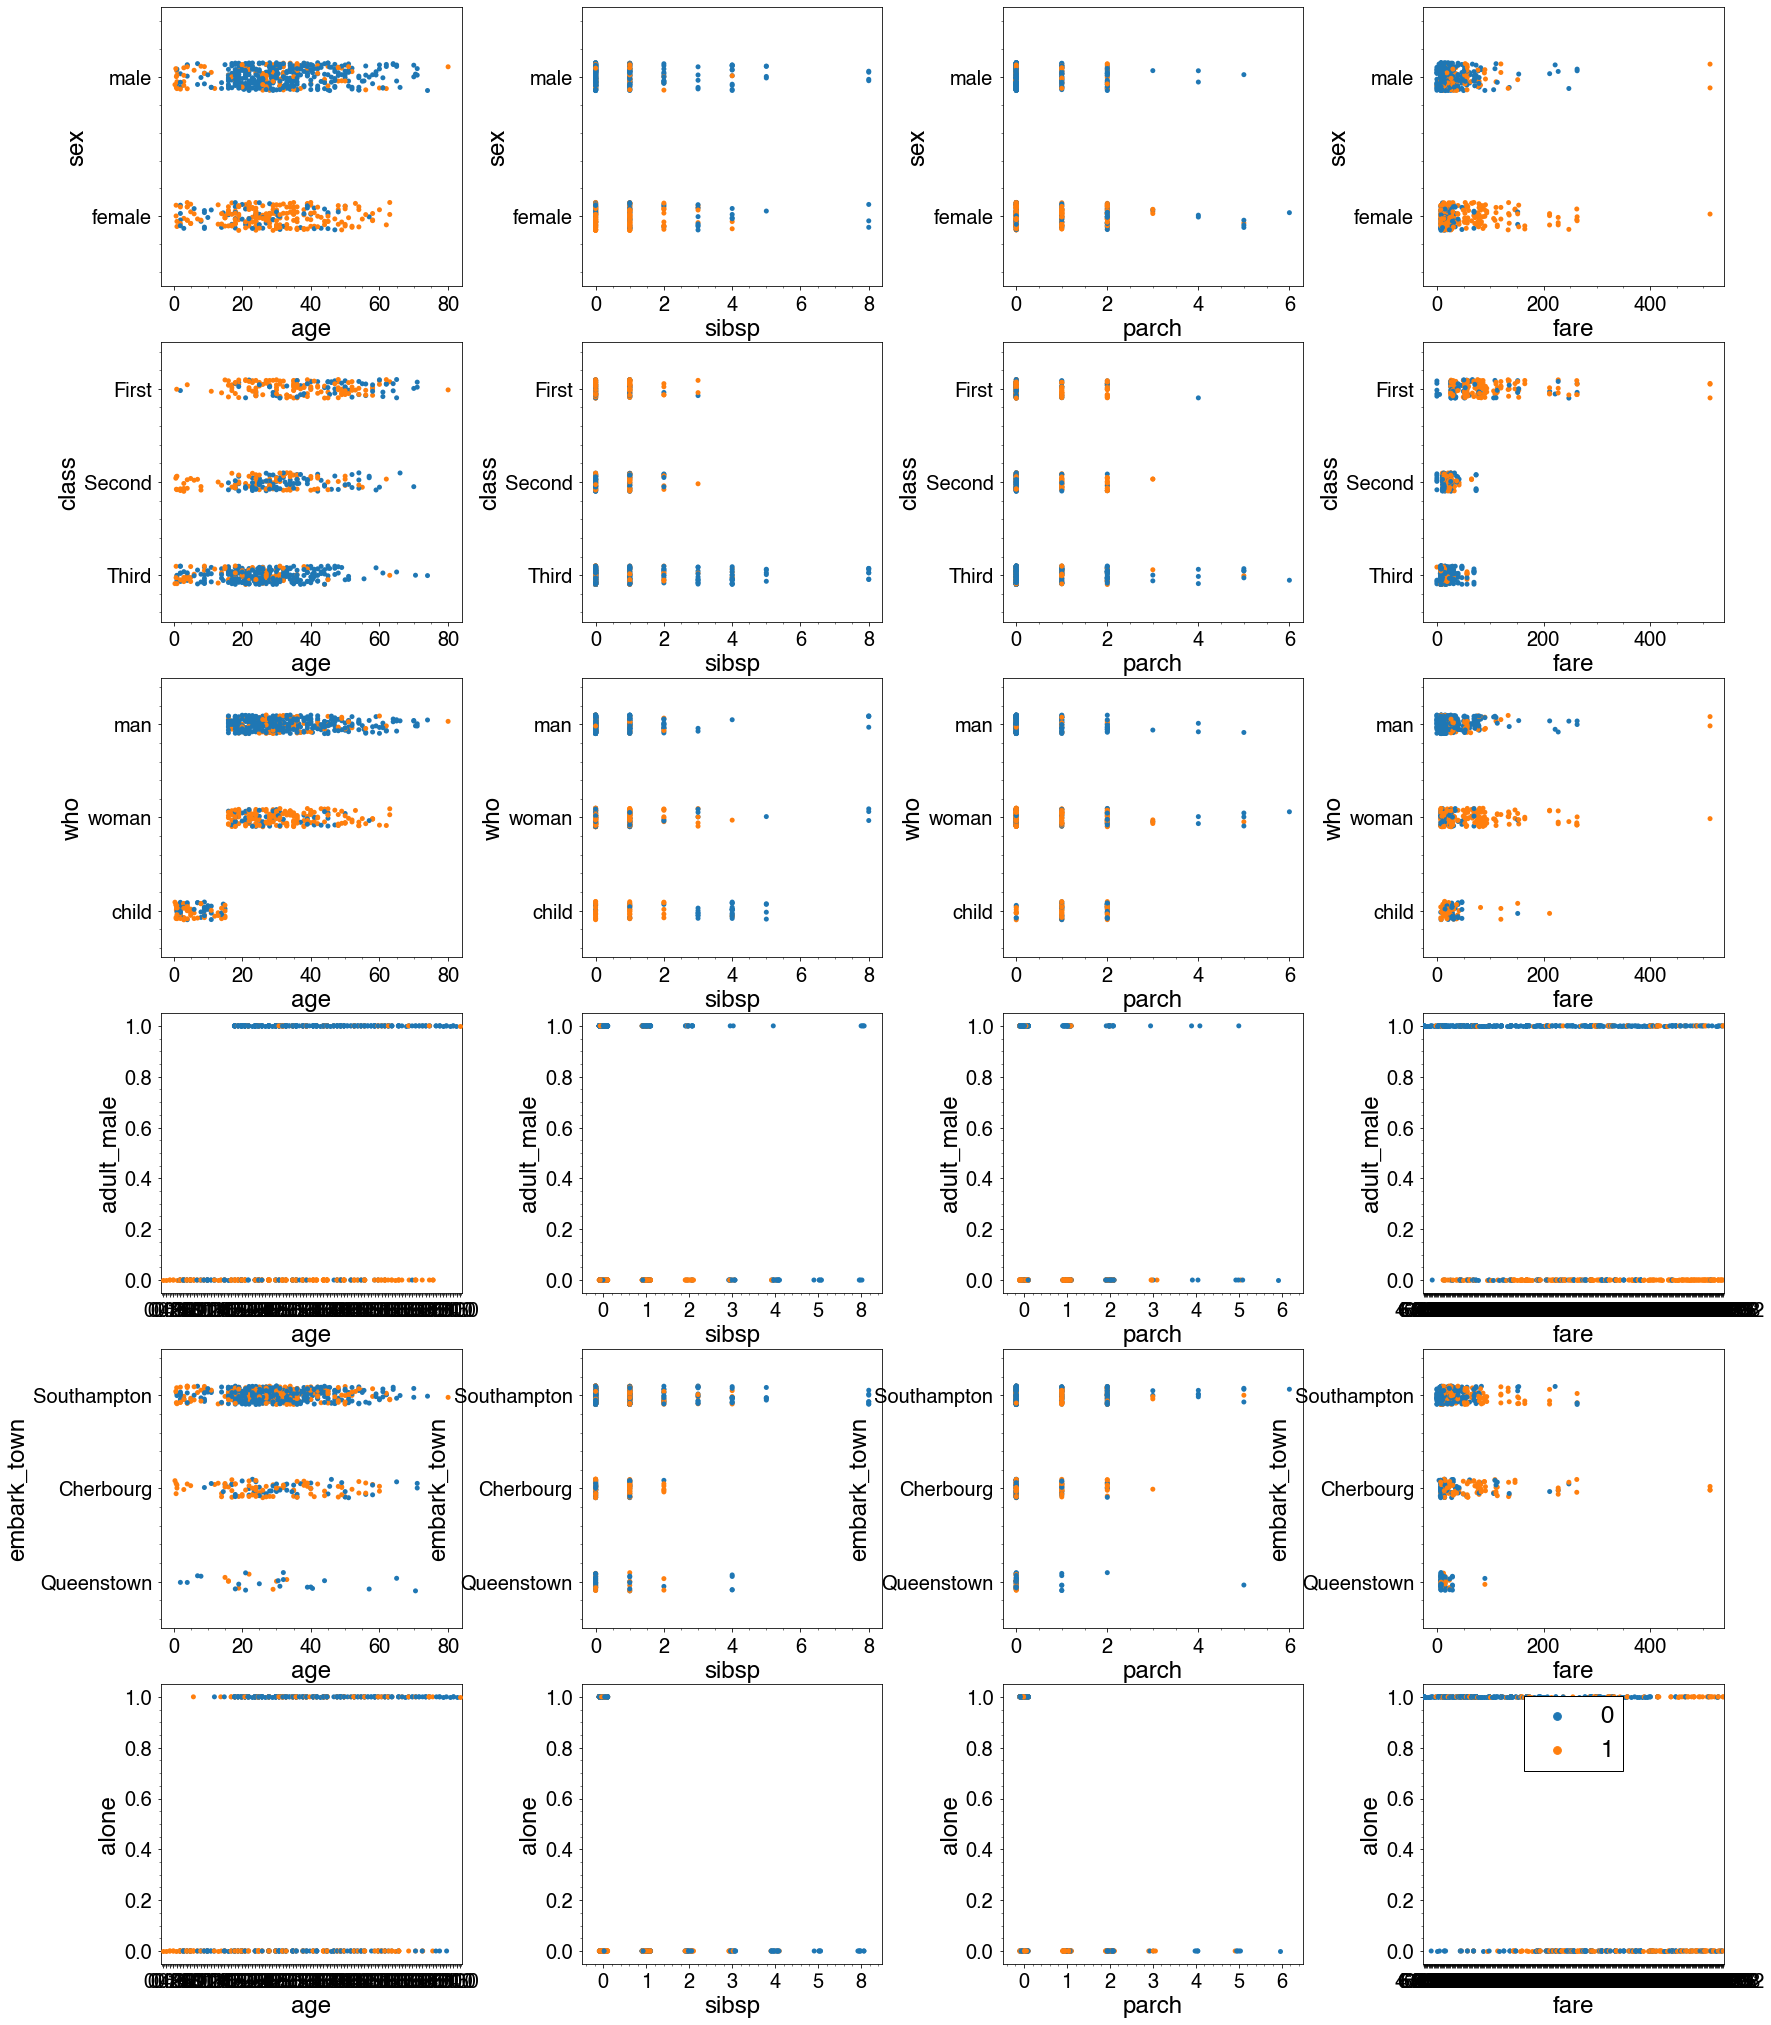

In [21]:
data_utils.make_pairwise_catplots(df, numerical_variables, categorical_variables, target_variable, row_feature="second")

From this plot, we can already see some trends. These are reinforced from what we saw in the contingency tables:
1. Females were more likely to survive than men. 
2. Among the males, the younger ones (children) were more likely to survive.
3. The field "who" shows the interaction between "sex" and "age". 
3. People in first class were more likely to survive than those in the others. 


### Learnings
1. From analyis, we learnt that the important variables are likely to be "sex", "age", "class". 
2. There are interactions between these variables; especially between "sex" and "age". The variable "who" denotes the interaction and therefore encodes the same information as them since men and women below the age of 20 are categorized as children. Thus, we remove the variable "who". 

In [37]:
categorical_variables.remove("who")

ValueError: list.remove(x): x not in list

## Next steps
Fit the model and visualize where it does well and where it fails based using the same utilities as before. 

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix,\
            ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import make_scorer


In [32]:
#Drop nan values and split into train and test. 
df_no_missing_vals = df[numerical_variables + categorical_variables + [target_variable]].dropna(axis=0, how="any").copy(deep=True)

#splitting into training and testing. 
df_train, df_test = train_test_split(df_no_missing_vals, test_size=0.2)


In [33]:
identity_trans = FunctionTransformer(func=lambda x: x, inverse_func=lambda x: x)

one_hot_trans = OneHotEncoder(drop="first")

category_preprocessing = Pipeline(steps=[('encoder', one_hot_trans)])

numerical_preprocessing = Pipeline(steps=[('normalizer', identity_trans)])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_preprocessing, numerical_variables),
    ('categorical', category_preprocessing, categorical_variables),
])

pipeline = Pipeline(steps = [('preprocessor', preprocessor),
            ('model', RandomForestClassifier(random_state=random_state))
                                                        ],)
parameters = {'model__n_estimators':np.arange(5,100, 50),
             'model__max_depth': np.arange(3,10, 5)}
                                        
accuracy_scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, labels=['1', '0'], pos_label='yes')
auc_scorer = make_scorer(roc_auc_score, labels=['1', '0'])


model = GridSearchCV(pipeline, 
                     parameters, 
                     scoring={"ROC_AUC": 'roc_auc'}, 
                    refit='ROC_AUC',
                    verbose=1,
                    n_jobs=-1,
                    cv=3,
                     error_score="raise",
                    return_train_score=True)

model.fit(df_train[numerical_variables + categorical_variables], df_train[target_variable])


Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('normalizer',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7fd309552550>,
                                                                                                              inverse_func=<function <lambda> at 0x7fd301fd6dc0>))]),
                                                                         ['age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                               

Scoring parameter: ROC_AUC


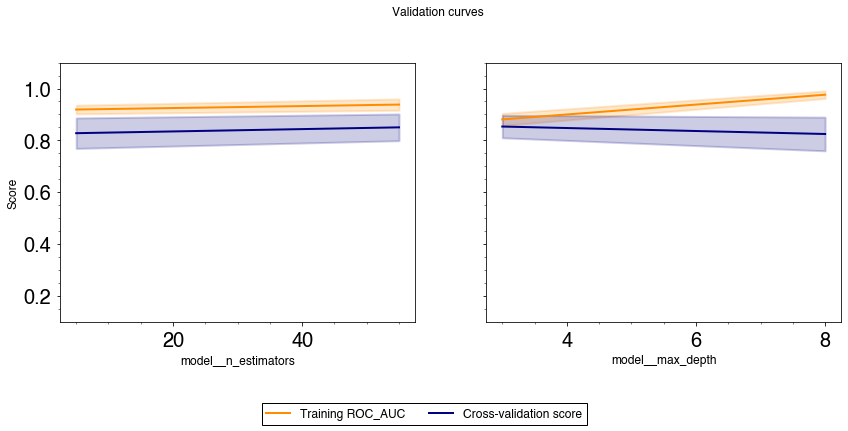

In [34]:
# Visualizing hyperparameters and their corresponding effects on model fitting. 
data_utils.plot_evaluation_curves(gs=model, grid_params=parameters)

<AxesSubplot:>

<Figure size 504x432 with 0 Axes>

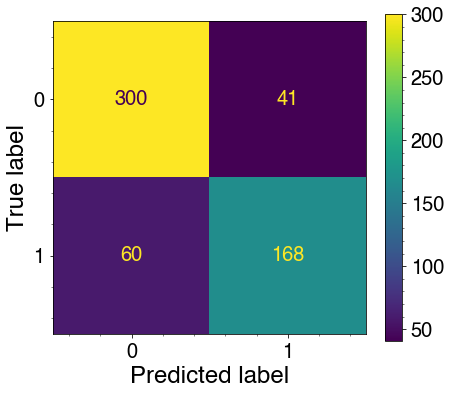

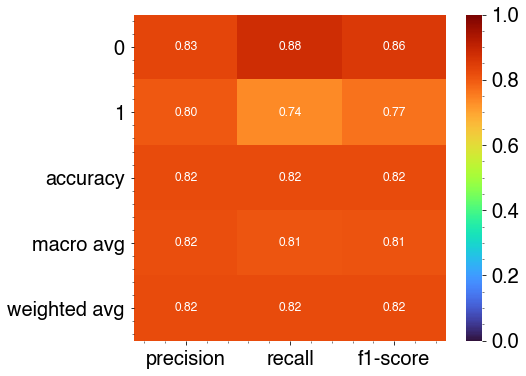

In [35]:
# Plot confusion matrix, and classification report. 
y_train_pred = model.predict(df_train[numerical_variables + categorical_variables])

plt.figure()
tr_con = confusion_matrix(df_train[target_variable], y_train_pred, labels=model.classes_)
ConfusionMatrixDisplay(tr_con, display_labels = model.classes_).plot()

plt.figure()
cr = classification_report(df_train[target_variable], y_train_pred, output_dict=True)
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, fmt=".2f", 
            annot_kws={"fontsize": 12}, vmin=0, vmax=1.0, cmap=plt.cm.turbo)

Text(0.5, 0, 'Feature importance')

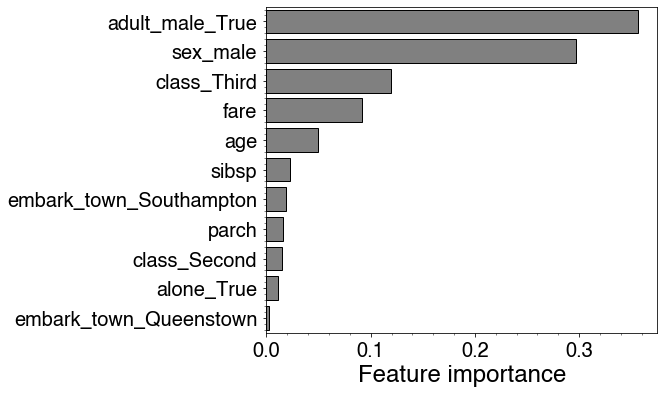

In [36]:
# Plot variable importance. 
numerical_variables_transforrmed = deepcopy(numerical_variables)
categorical_variables_transformed = model.best_estimator_['preprocessor'].transformers_[1][1]\
    ['encoder'].get_feature_names(categorical_variables).tolist()

full_feature_list = numerical_variables_transforrmed + categorical_variables_transformed

feature_imp_RF = pd.Series(model.best_estimator_[1].feature_importances_, 
                      index=full_feature_list).sort_values(ascending=False)

plt.figure()
sns.barplot(x=feature_imp_RF, y=feature_imp_RF.index, color="gray")
plt.xlabel("Feature importance")

__*Conclusion:*__ The variables that the model shows to be important align with what we were able to see through EDA. 

### Where does the model fail?

In [28]:
df_train["AccuratePrediction"] = (df_train[target_variable] == y_train_pred).values

<ipython-input-28-14e0fc66fca1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["AccuratePrediction"] = (df_train[target_variable] == y_train_pred).values


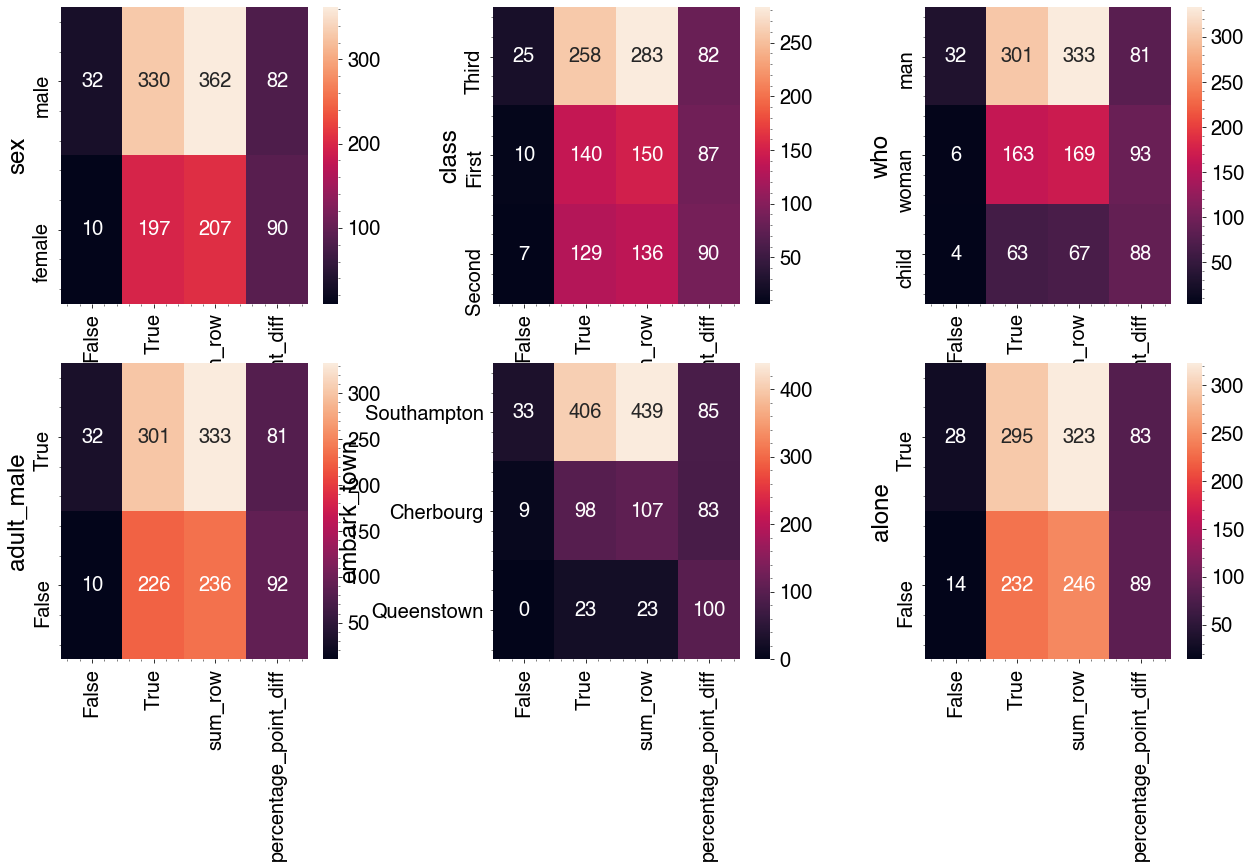

In [29]:
data_utils.make_contingency_tables_for_binary(df_train, categorical_variables, target_var="AccuratePrediction" ,
                                              ncols=3)

Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1006 ticks ([-0.4, ..., 200.6]), which exc

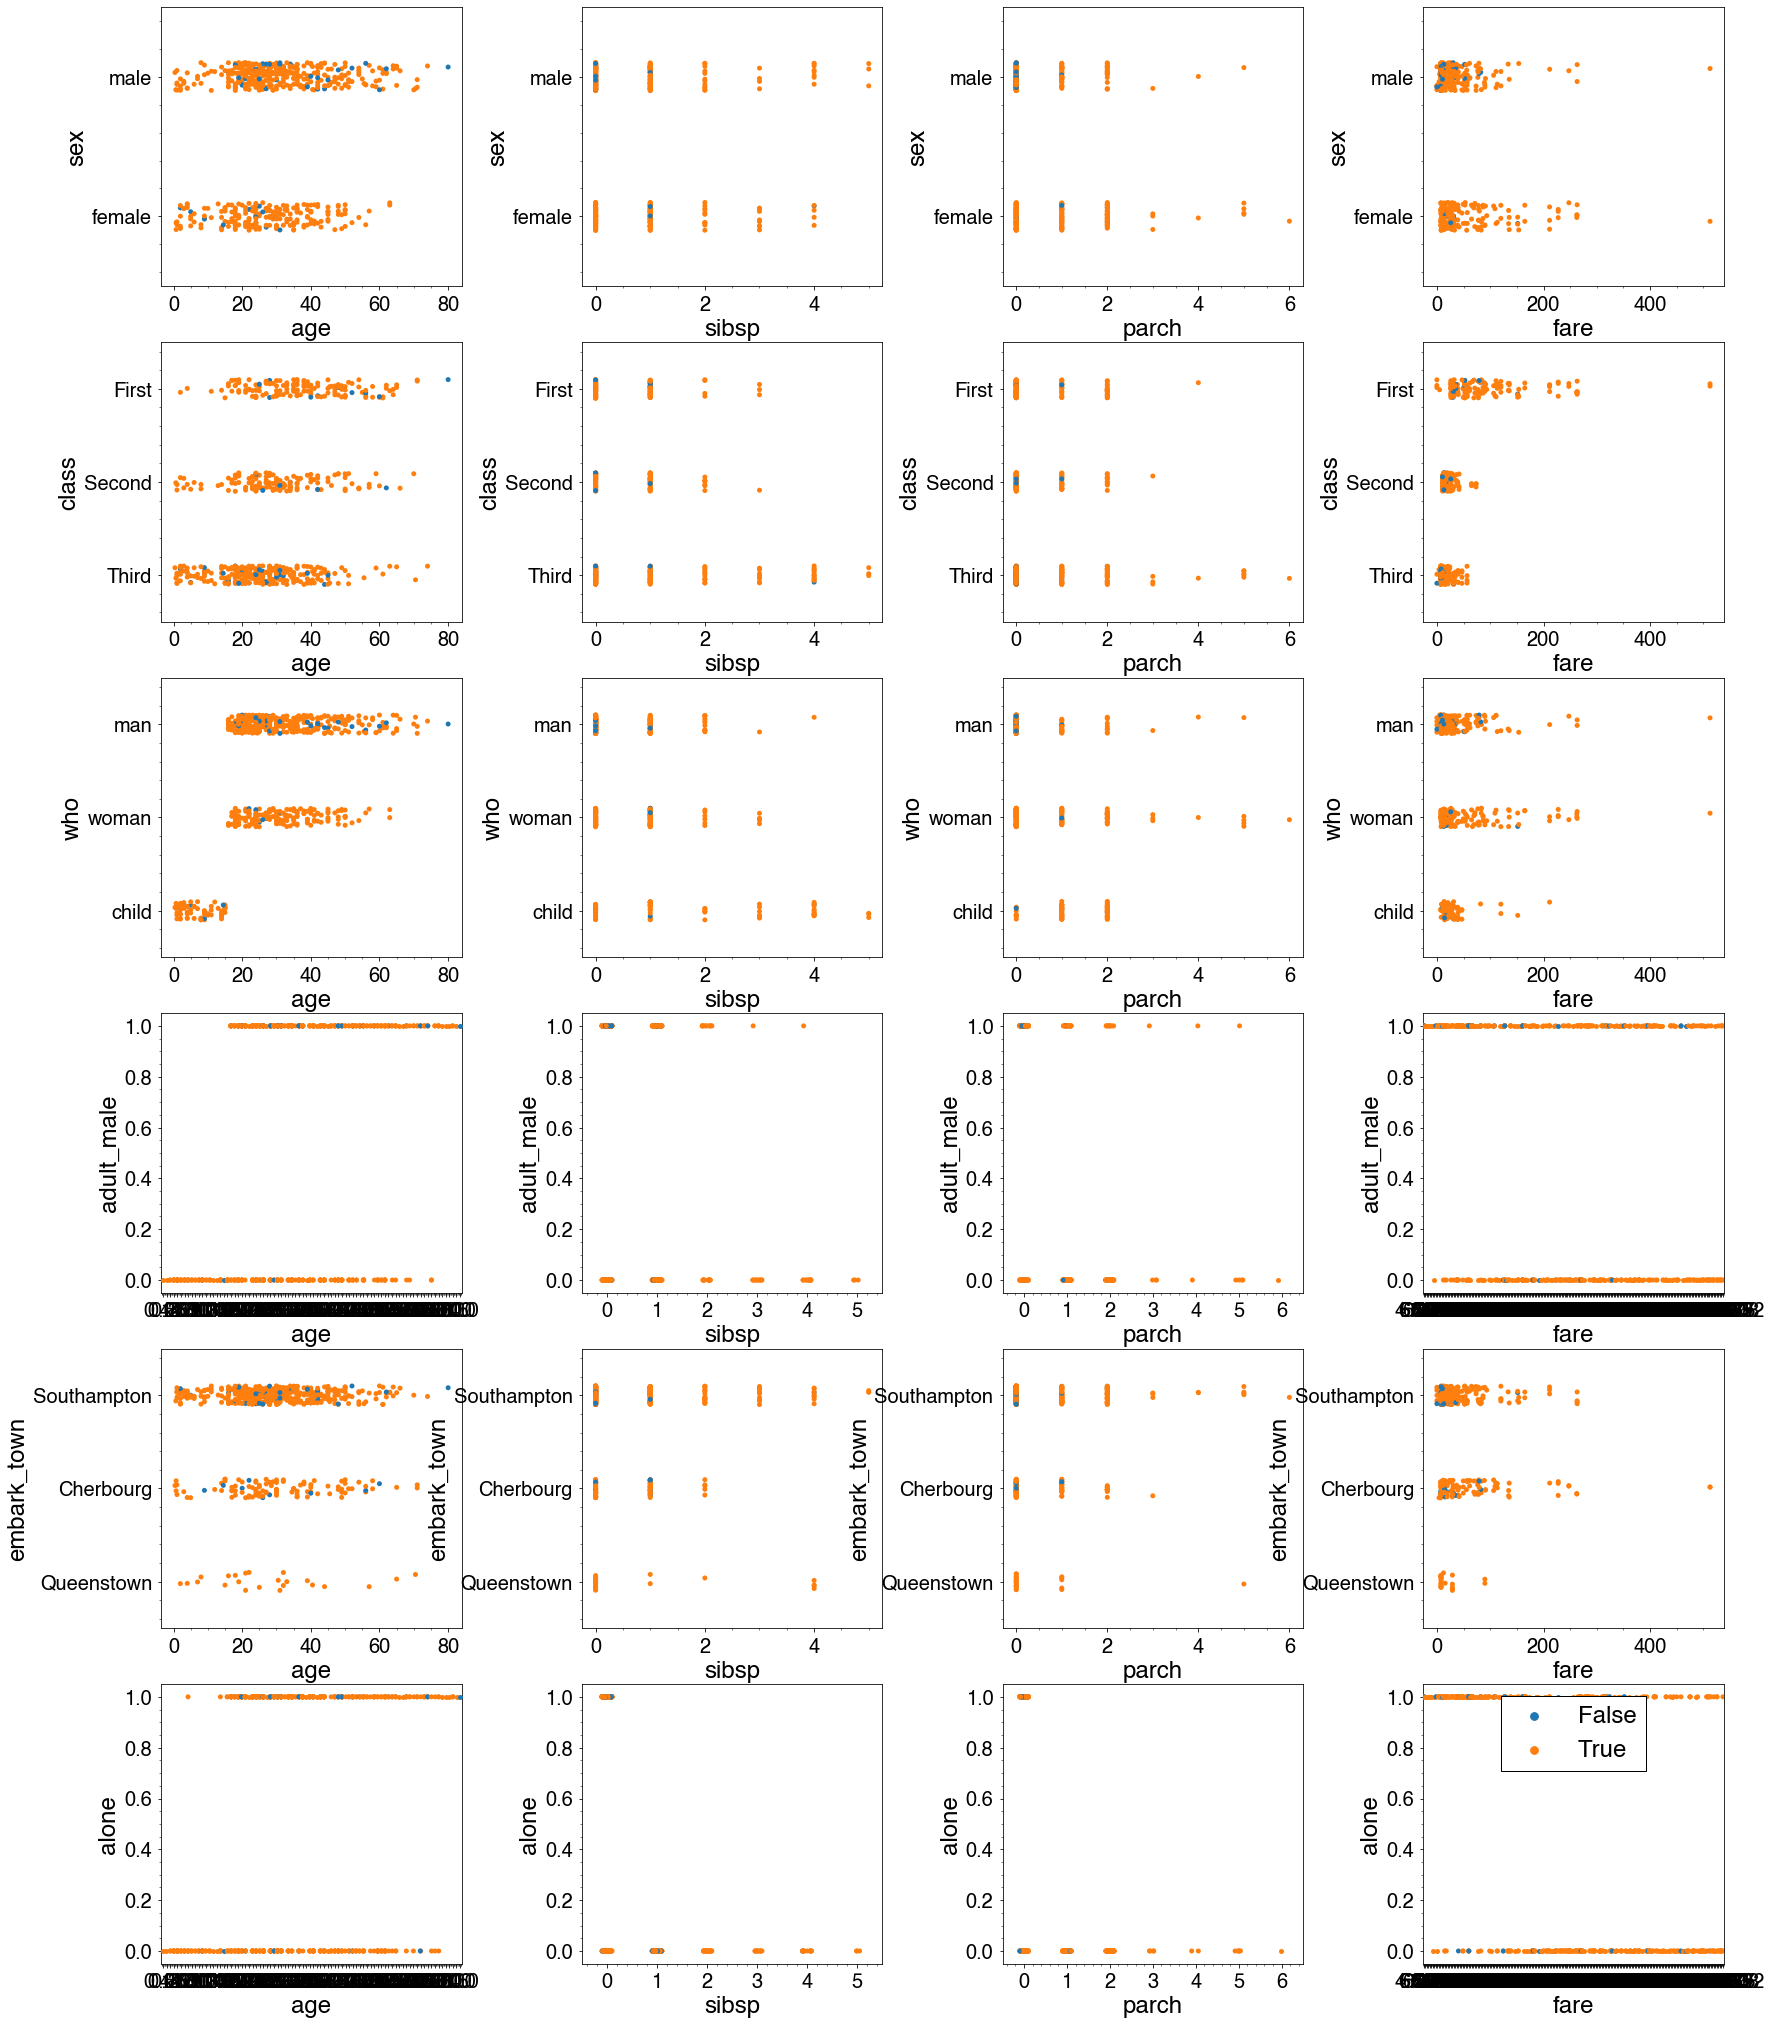

In [30]:
data_utils.make_pairwise_catplots(df_train, numerical_variables, categorical_variables, "AccuratePrediction", row_feature="second")

*__Learning:__* Since the _percentage_point_differences_ are more or less uniform, it means that the model predicts about the same everywhere. 